# Tutorial 17: Coherent Spatio-Temporal Scale-separation (CoSTS) with DMD

In this tutorial we build a toy data set:
- An oscillator with nearly overlapping frequencies between two dynamic systems
- An added transient feature.
- All influenced by a white noise process.

The CoSTS algorithm can be used to separate out each of these individual components, albeit with some hyperparameter tuning. Bad sets of hyperparameters are often indicated by poorly reconstructed windows. However, a sufficiently high level of noise or too large of an initial window can mask the transient feature, which drops out for the next decomposition levels.

## Imports

In [1]:
# netcdf/numpy/xray/stats
import numpy as np
import copy
import scipy
from scipy.integrate import solve_ivp
from pydmd.costs import COSTS

# import plotting
import seaborn as sns
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")

## Format plots

In [2]:
%matplotlib inline
# Higher resolution figures within the notebook
%config InlineBackend.figure_format = 'retina'

# Set the plot style from the seaborn library
sns.set_style("whitegrid")
context = "paper"
sns.set_context(context)

# Tol bright color scheme reordered to put my favorite colors first
tol_bright_reorder = [
    "#4477AA",
    "#CCBB44",
    "#EE6677",
    "#228833",
    "#66CCEE",
    "#AA3377",
    "#BBBBBB",
]
sns.set_palette(sns.color_palette(tol_bright_reorder))

# Set up toy data

## Solve the Overlapping-Scale Oscillators Example

- FitzHugh-Nagumo Model
- Unforced Duffing Oscillator


From Dylewsky et al., (2019):

"The FitzHugh-Nagumo model, used as a simple model for biological neuron dynamics, spikes sharply at intervals determined by its characteristic time scale. The Duffing model, on the other hand, is a simple nonlinear oscillator whose dynamics resemble a distorted sinusoid. Therefore, despite the disparity between τ1 and τ2, the “slow” component periodically acquires a rate of change comparable to that of the “fast” component."

In [3]:
def rhs_FNM(t, x, tau, a, b, Iext):
    # FitzHugh-Nagumo Model
    v = x[0]
    w = x[1]
    vdot = v - (v**3) / 3 - w + Iext
    wdot = (1 / tau) * (v + a - b * w)
    dx = np.array([vdot, wdot])

    return dx


def rhs_UFD(t, y, eta, epsilon, tau):
    # Unforced Duffing Oscillator
    p = y[0]
    q = y[1]
    pdot = q
    qdot = (1 / tau) * (-2 * eta * q - p - epsilon * p**3)
    dy = np.array([pdot, qdot])

    return dy


T = 64

x0 = np.array([-1.110, -0.125])
tau1 = 2
a = 0.7
b = 0.8
Iext = 0.65

y0 = np.array([0, 1])
eta = 0  # dampling
epsilon = 1
tau2 = 0.2

# RK4 integration of the mixed system
dt = 0.0001 * 8
# dt = 0.01
time = np.arange(0, T, dt)

solution_FN = solve_ivp(
    rhs_FNM, [0, T], x0, t_eval=time, args=(tau1, a, b, Iext)
)

solution_UFD = solve_ivp(
    rhs_UFD, [0, T], y0, t_eval=time, args=(eta, epsilon, tau2)
)

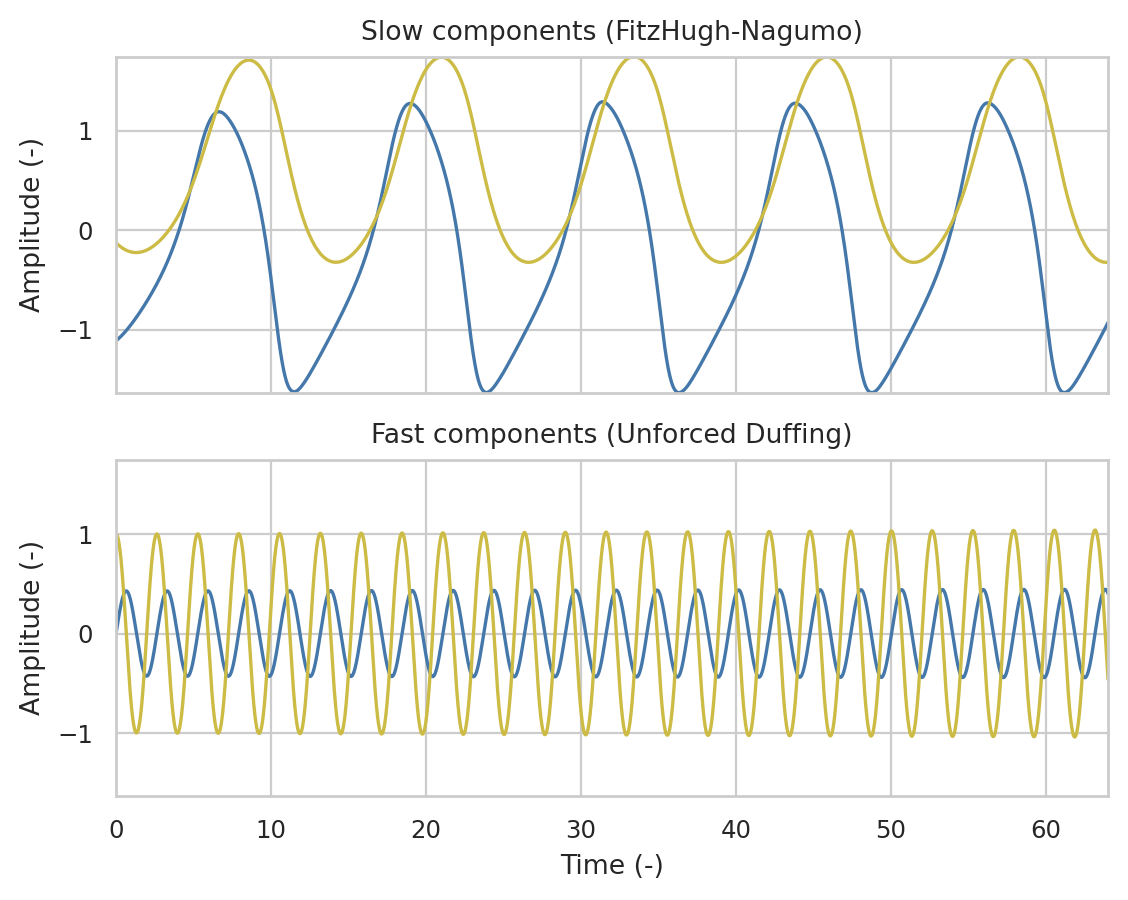

In [4]:
fig, axes = plt.subplots(2, 1, sharex=True, sharey=True)
ax = axes[0]
ax.plot(time, solution_FN.y.T)
ax.set_title("Slow components (FitzHugh-Nagumo)")
ax.set_ylabel("Amplitude (-)")
ax.autoscale(enable=True, axis="both", tight=True)

ax = axes[1]
ax.plot(time, solution_UFD.y.T)
ax.set_title("Fast components (Unforced Duffing)")
ax.set_ylabel("Amplitude (-)")
ax.set_xlabel("Time (-)")
ax.autoscale(enable=True, axis="both", tight=True)

plt.show()

## Applying linear mixing of the two non-linear oscillators

Here we encounter a difficult problem: the original toy data set has an INCREDIBLY high condition number (~10^15). So much so that perturbations to the problem (e.g., white noise) or changes in hyperparameters (e.g., window length) make the problem very difficult. Generally, the toy data sets considered in all optDMD/BOP-DMD/mrDMD manuscripts suffer from this problem. I've tried to mitigate this as much as possible through using all of the variables output by the solution to this toy data set ($p$, $q$, $v$, and $w$) instead of just 2 of them and by enforcing the ortho-normal properties of the linear mixture.

However, the toy data system is still not robust to added noise or changes to hyperparameters. My hope is this weakness speaks more to the toy data and less to the actual algorithm. Generally it takes a few iterations to find a reasonable set of hyperparameters. The biggest indicator of a poor set of hyperparameters is poorly fit windows/unreasonable reconstructions.

In [5]:
# Modified for this toy example to use all components.
uv = np.vstack([solution_FN.y, solution_UFD.y]).T

# ratio of u and v in linear combination
uv_ratio = 1

n = np.shape(uv)[1]
m = np.shape(uv)[0]

# Dimension of space to map into
nVars_out = 4

Conditon number of toy data (smaller is better): 3.70


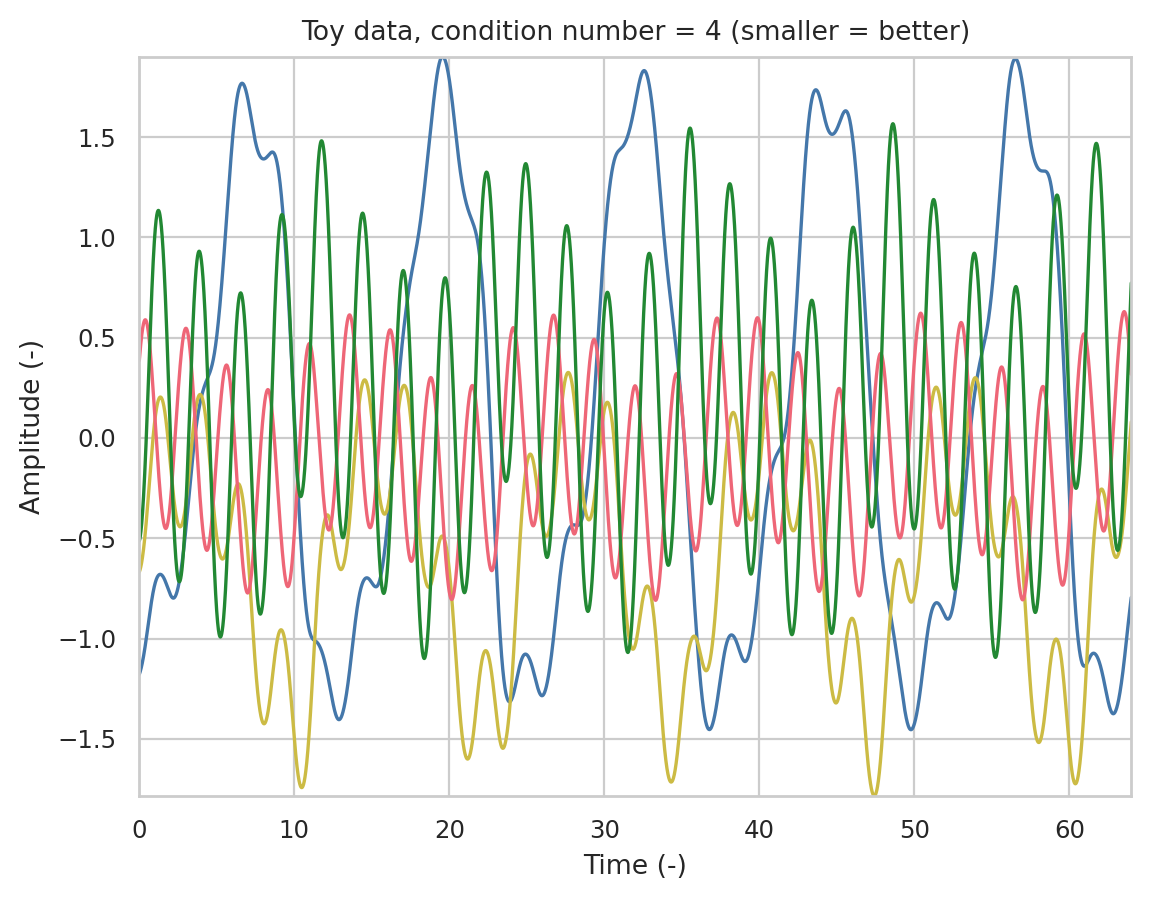

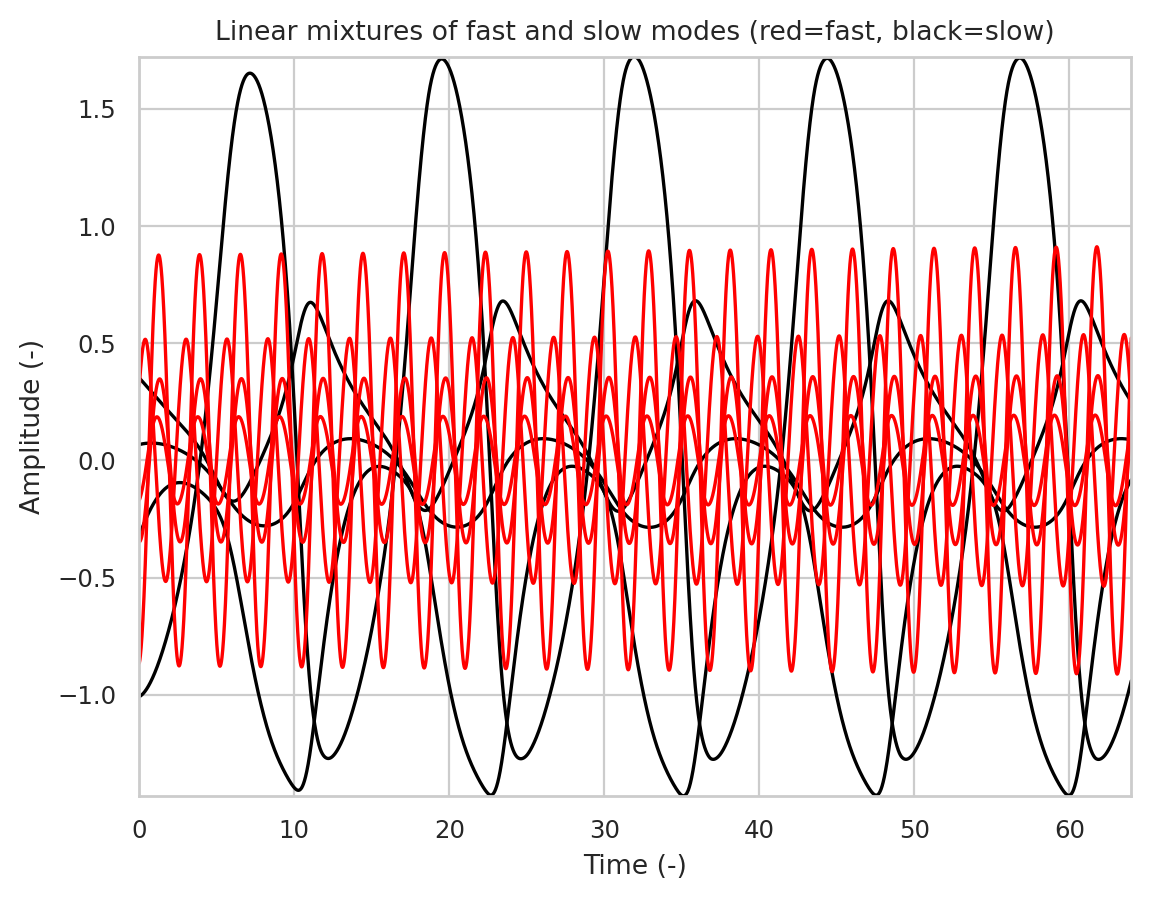

In [6]:
seed = 1
rng = np.random.default_rng(seed)

# Orthonormalized linear mixing matrix
Q = scipy.stats.ortho_group.rvs(nVars_out, random_state=seed)
Q = Q[0:4, :]

A = rng.normal(size=(n, nVars_out))

# Here it is important to note the original publication
# did not actually perform the orthonormalizing but instead
# did the linear mixing with a gaussian-random matrix. We do not
# do that here to make the condition number manageable.
x = uv @ Q
x = x.T

print(
    "Conditon number of toy data (smaller is better): {:.2f}".format(
        np.linalg.cond(x)
    )
)

slow_modes = solution_FN.y.T @ Q[0:2, :]
fast_modes = solution_UFD.y.T @ Q[2:4, :]

fig, ax = plt.subplots(1, 1)
ax.plot(time, x.T)
ax.set_title(
    "Toy data, condition number = {:.0f} (smaller = better)".format(
        np.linalg.cond(x)
    )
)
ax.set_xlabel("Time (-)")
ax.set_ylabel("Amplitude (-)")
ax.autoscale(enable=True, axis="both", tight=True)

fig, ax = plt.subplots(1, 1)
ax.plot(time, slow_modes, "k")
ax.plot(time, fast_modes, "r")
ax.set_title("Linear mixtures of fast and slow modes (red=fast, black=slow)")
ax.set_ylabel("Amplitude (-)")
ax.autoscale(enable=True, axis="both", tight=True)
ax.set_xlabel("Time (-)")
plt.show()

## Add a transient feature

Conditon number of toy data (smaller is better): 3.38


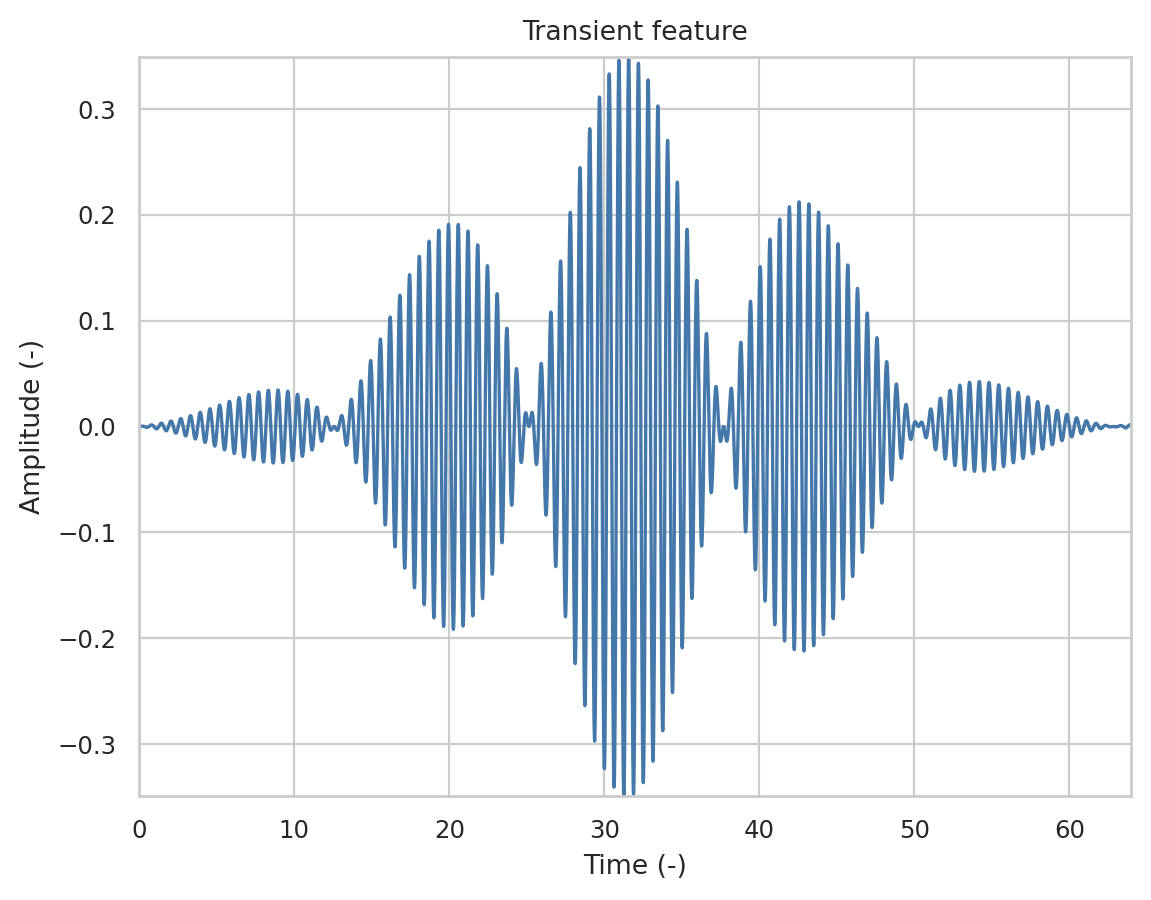

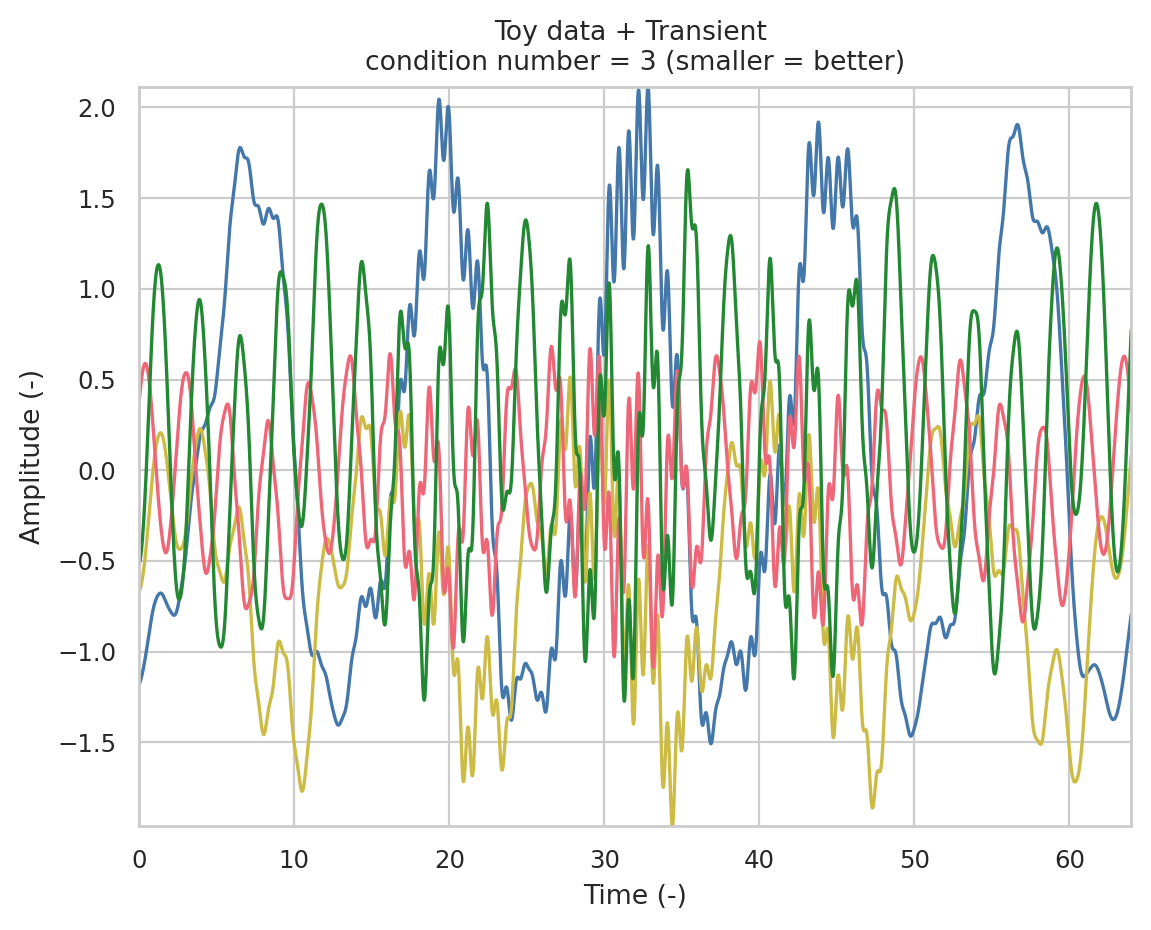

In [7]:
# recon_filter_sd = 15000
recon_filter_sd = len(time) * 0.25
n_time = x.shape[1]

recon_filter = np.exp(
    -((np.arange(n_time) - (n_time + 1) / 2) ** 2) / recon_filter_sd**2
)
recon_filter[recon_filter < 0.0001] = 0

fig, ax = plt.subplots(1, 1)
f_transient = 10
x_transient = (
    0.35
    * np.sin(f_transient * time.flatten())
    * np.sin(0.25 * time.flatten())
    * recon_filter
)
ax.plot(time.flatten(), x_transient.T)
ax.set_title("Transient feature")
ax.set_ylabel("Amplitude (-)")
ax.set_xlabel("Time (-)")
ax.autoscale(enable=True, axis="both", tight=True)

# Add the transient feature to the data
data = x + np.atleast_2d(x_transient)

fig, ax = plt.subplots(1, 1)
ax.plot(time.flatten(), data.T)
ax.set_title(
    (
        "Toy data + Transient \n"
        "condition number = {:.0f} (smaller = better)".format(
            np.linalg.cond(data)
        )
    )
)
ax.set_ylabel("Amplitude (-)")
ax.set_xlabel("Time (-)")
ax.autoscale(enable=True, axis="both", tight=True)

print(
    "Conditon number of toy data (smaller is better): {:.2f}".format(
        np.linalg.cond(data)
    )
)
plt.show()

## Add white noise

Conditon number of toy data (smaller is better): 3.38


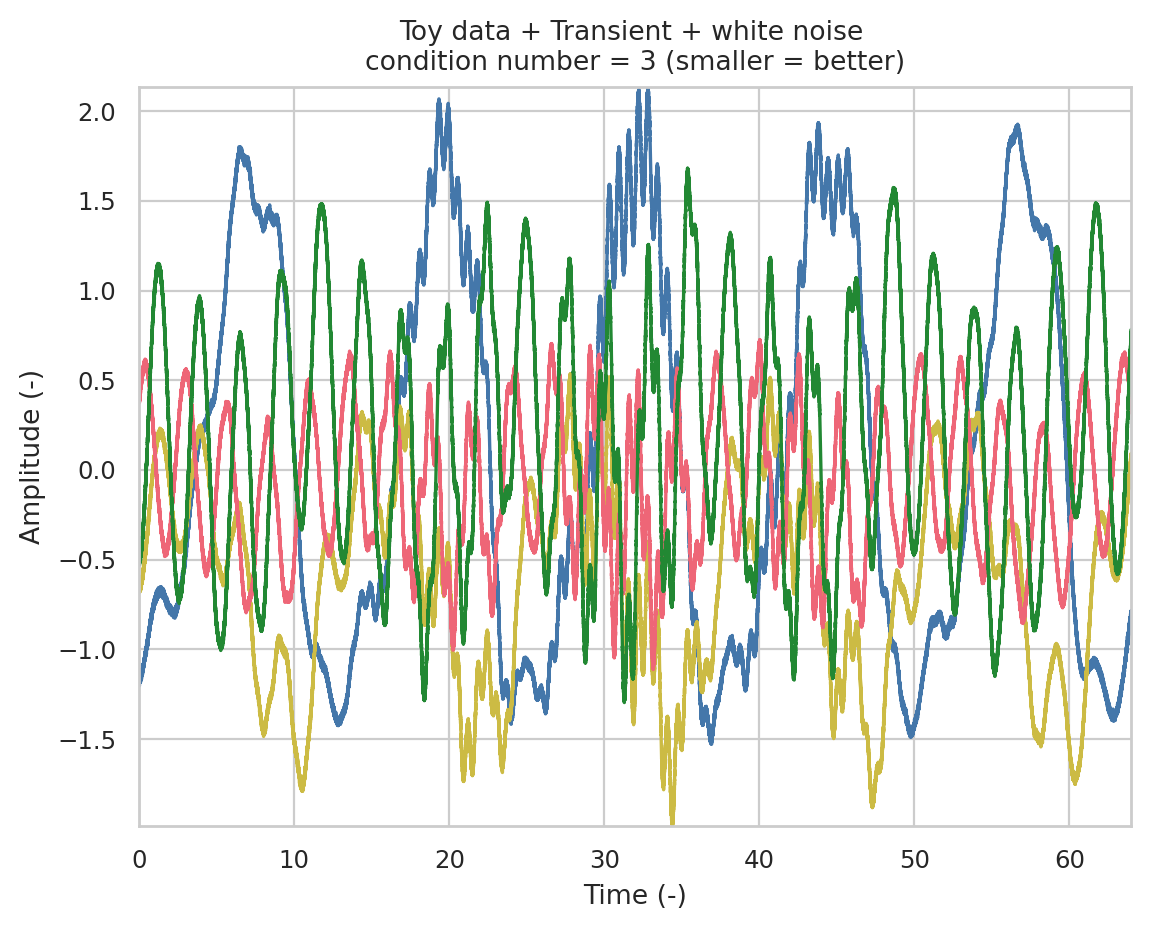

In [8]:
# Adding noise absolutely wrecks the mrd fit. Which is frowing emoji.
data = data + rng.normal(0, 0.01, size=(nVars_out, m))

fig, ax = plt.subplots(1, 1)
ax.plot(time.flatten(), data.T)
ax.set_title(
    (
        "Toy data + Transient + white noise \n"
        "condition number = {:.0f} (smaller = better)".format(
            np.linalg.cond(data)
        )
    )
)
ax.set_ylabel("Amplitude (-)")
ax.set_xlabel("Time (-)")
ax.autoscale(enable=True, axis="both", tight=True)


print(
    "Conditon number of toy data (smaller is better): {:.2f}".format(
        np.linalg.cond(data)
    )
)

plt.show()

# mrCOSTS

## Settings

### Choosing window sizes

How big should the window be? This is a non-trivial question. First, let's find the number of time steps in a single cycle for the high frequency transient feature.

In [12]:
dt = scipy.stats.mode(np.diff(time.flatten()))[0]

num_steps_cycle = (2 * np.pi / f_transient) / dt
print(
    "Number of time steps per cycle of the transient feature: {:.0f}".format(
        num_steps_cycle[0]
    )
)

Number of time steps per cycle of the transient feature: 785


Based on this and Dylewsky we should have a window size somewhere around 2 * the period of the fastest feature. 

When the window is too large and/or the svd rank is too small to fit the data well, these high frequency features are simply dropped. This behavior can be accidentally nice when wanting to ignore high frequency components anyway.

For more brittle data, i.e. this toy data set, the window size is deeply important for isolating the features of interest. Changing the window sizes will degrade the performance of the scale-separation. 

Fortunately, for real data with more continuously distributed frequency bands the window size selection is less impactful. Real data with many features present tend to be more forgiving since features missed at a smaller decomposition scale can be picked up at a larger decomposition scale.


### Settings
- Some of these settings (specifically `eig_constraints` and `global_svd=True`) do not work well on real data but seem to be necessary for this toy data set.
- `global_svd=True` is not recommended for real data but is necessary for speeding up the analysis of the toy data in which we have very narrow frequency bands present.
- `svd_rank` cannot be larger than the number of spatial dimensions. For 4 spatial dimensions that means we can never resolve more than a low and high frequency scale separation due to the requirement of a conjugate pairs in the eigenvalues.
- `transform_method` dictates how the eigenvalue frequencies (the imaginary components) are transformed for the scale-separation step. See the below histograms for an illustration. Generally, for real data we find that `transform_method="absolute_value"` is the more reliable option.
- `suppress_growth` triggers whether the real positive component of an eigenvalue is killed when doing reconstructions. This keyword should not always be true as real data can contain non-linearities that need to be modeled using positive growth.

## Drive the recursive decomposition

To Do:

- `window_length` and `step_sizes` as a function of dt?
- Move to using mrCOSTS method instead of manually iterating.

In [14]:
# Window size (in time steps)
window_lengths = np.array([1500, 6000])
step_sizes = np.array([100, 400])
svd_ranks = [4] * len(window_lengths)
num_decompositions = len(window_lengths)
mrd_list = []
suppress_growth = False
transform_method = "square_frequencies"

data_iter = np.zeros((num_decompositions, data.shape[0], data.shape[1]))
data_iter[0, :, :] = data

for n_decomp, (window, step, rank) in enumerate(
    zip(window_lengths, step_sizes, svd_ranks)
):
    print("Working on window length={}".format(window))

    x_iter = data_iter[n_decomp, :, :].squeeze()
    mrd = COSTS(
        svd_rank=rank,
        global_svd=True,
        pydmd_kwargs={"eig_constraints": {"conjugate_pairs", "stable"}},
    )

    print("Fitting")
    print("_________________________________________________")
    mrd.fit(x_iter, np.atleast_2d(time), window, step, verbose=True)
    print("_________________________________________________")

    # Force the clustering to use two components due to the nature of the toy data.
    _ = mrd.cluster_omega(n_components=2, transform_method=transform_method)

    # Global reconstruction error indicates if a good set of hyperparameters were chosen.
    global_reconstruction = mrd.global_reconstruction(
        {"suppress_growth": suppress_growth}
    )
    re = mrd.relative_error(global_reconstruction.real, x_iter)
    print("Error in Global Reconstruction = {:.2}".format(re))

    # Scale separation
    xr_low_frequency, xr_high_frequency = mrd.scale_separation(
        scale_reconstruction_kwargs={"suppress_growth": suppress_growth}
    )

    # Pass the low frequency component to the next level of decomposition.
    if n_decomp < num_decompositions - 1:
        data_iter[n_decomp + 1, :, :] = xr_low_frequency

    # Save the object for later use.
    mrd_list.append(copy.copy(mrd))

Working on window length=1500
Fitting
_________________________________________________
0 of 786
50 of 786
100 of 786
150 of 786
200 of 786
250 of 786
300 of 786
350 of 786
400 of 786
450 of 786
500 of 786
550 of 786
600 of 786
650 of 786
700 of 786
750 of 786
_________________________________________________
Error in Global Reconstruction = 0.023
Working on window length=6000
Fitting
_________________________________________________
0 of 186
50 of 186
100 of 186
150 of 186
_________________________________________________
Error in Global Reconstruction = 0.05


## Visualize the results

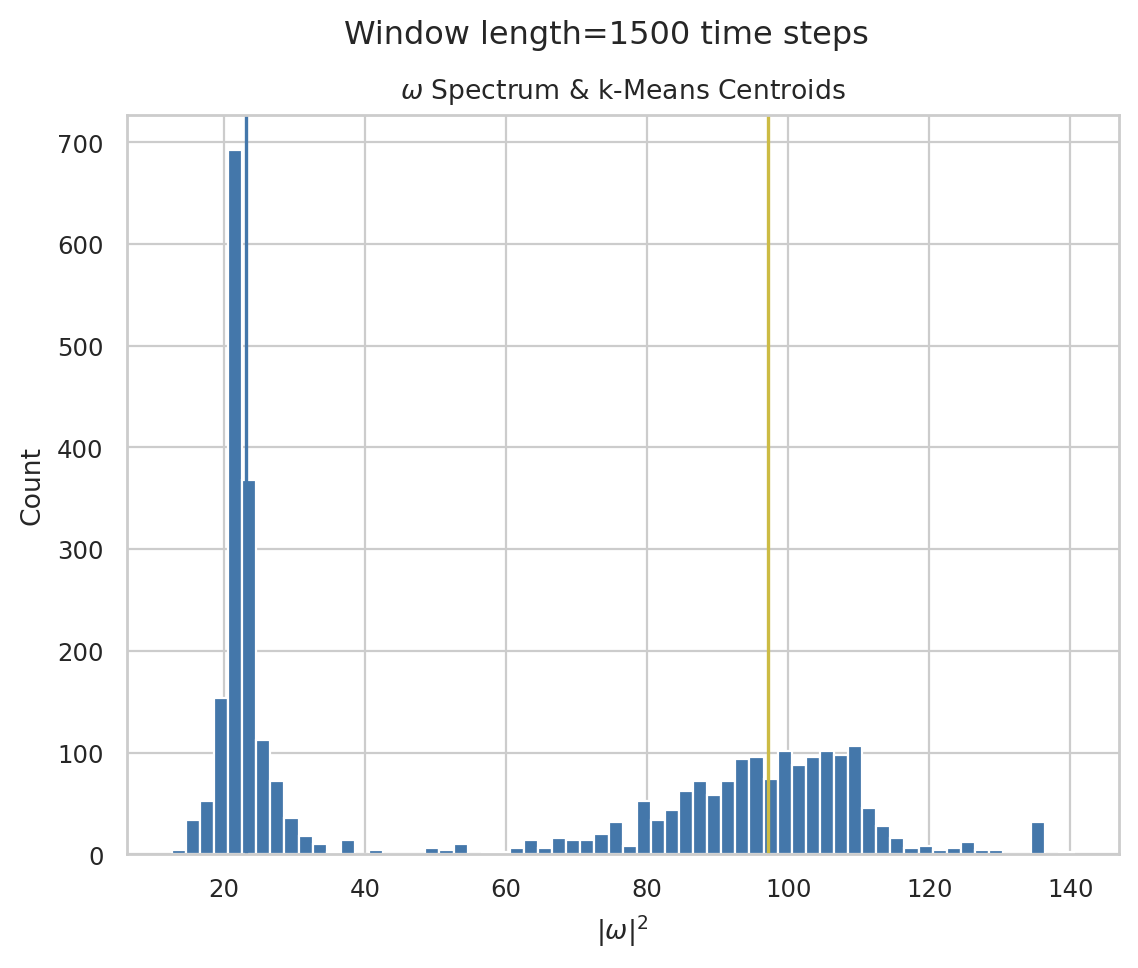

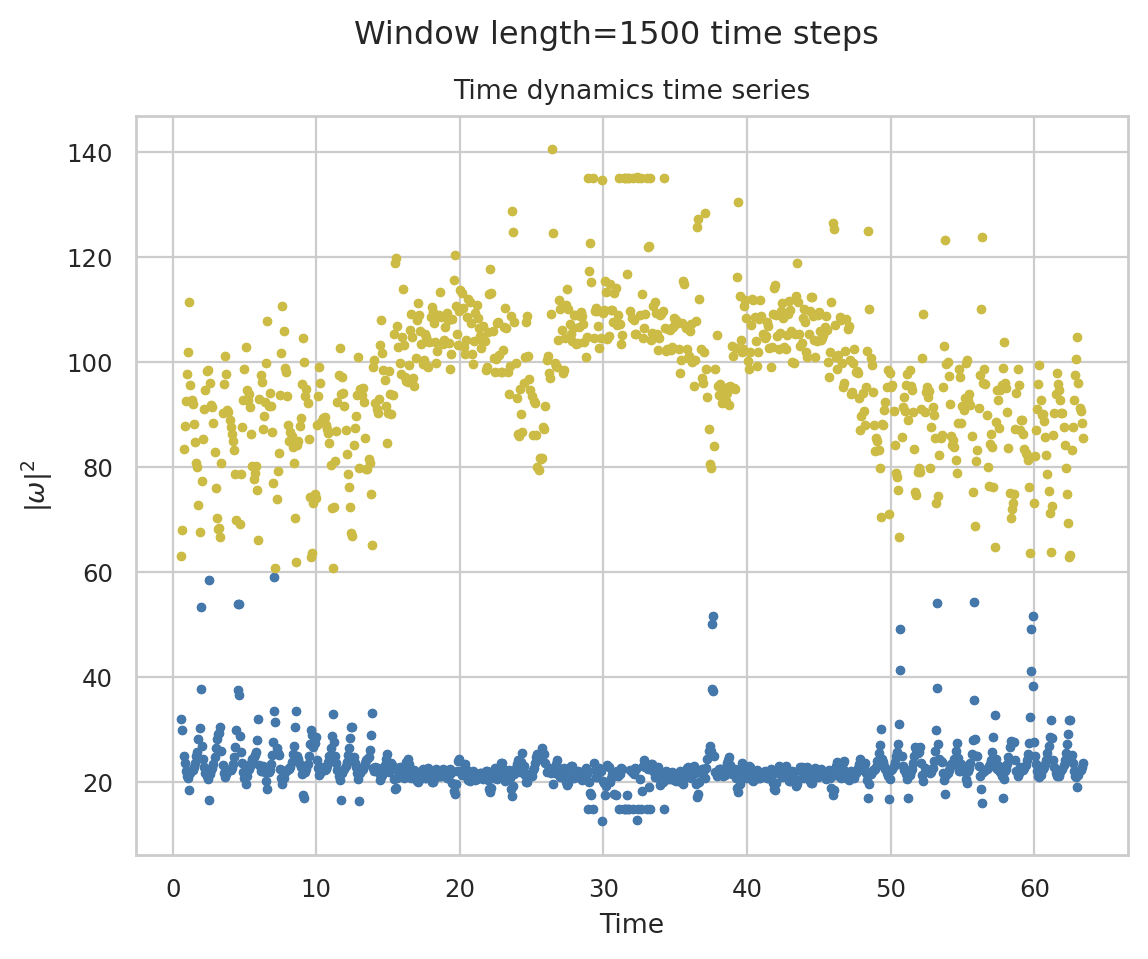

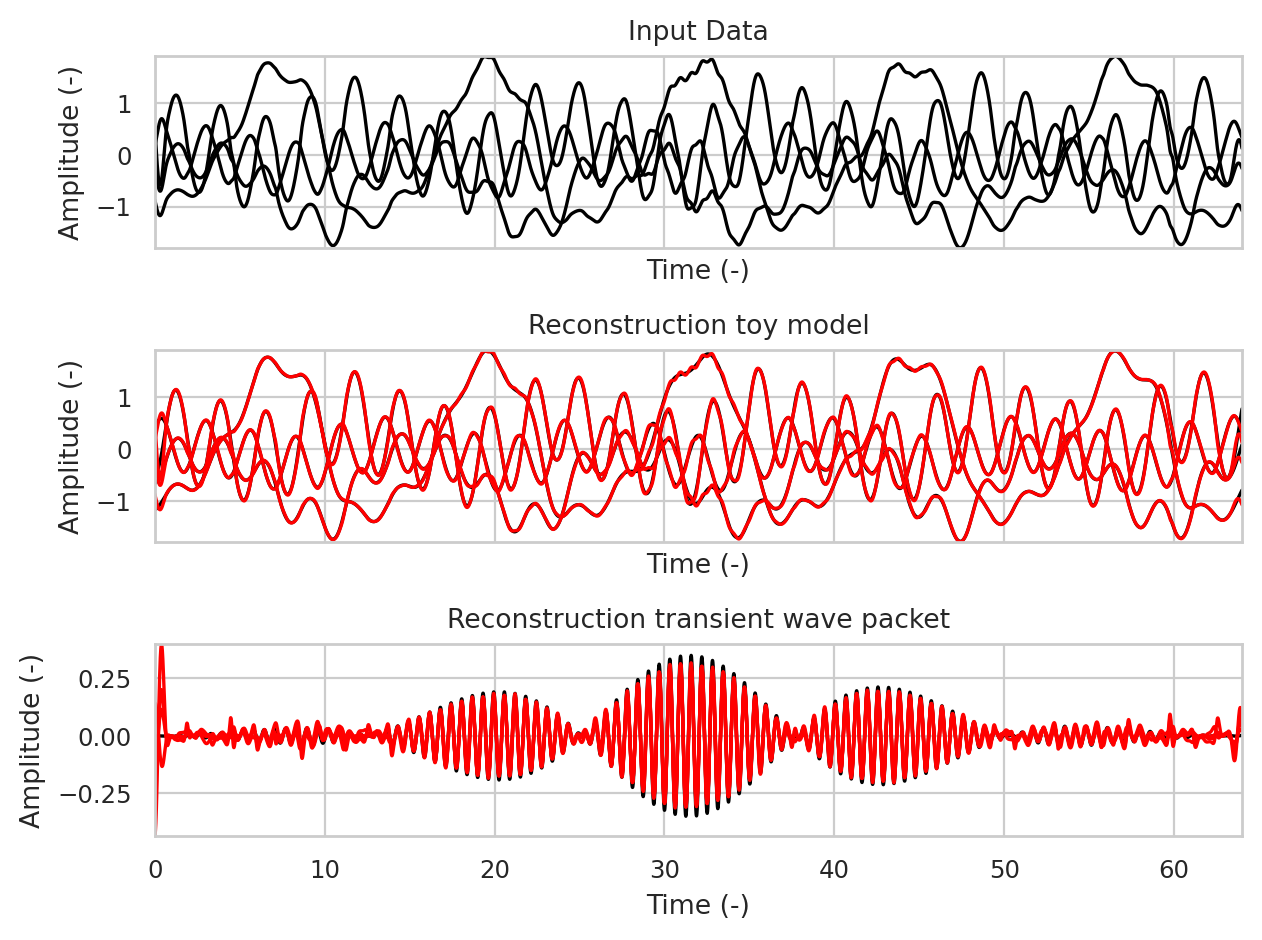

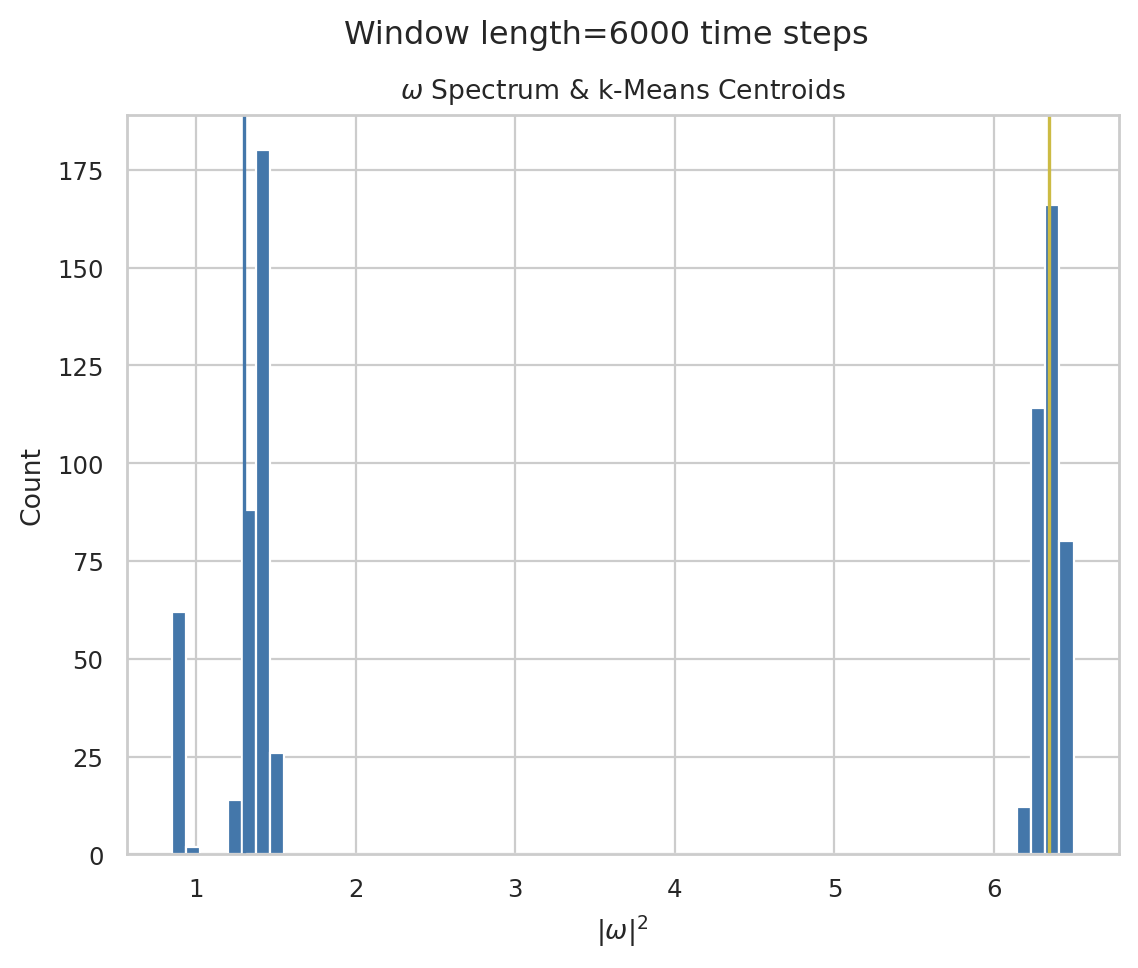

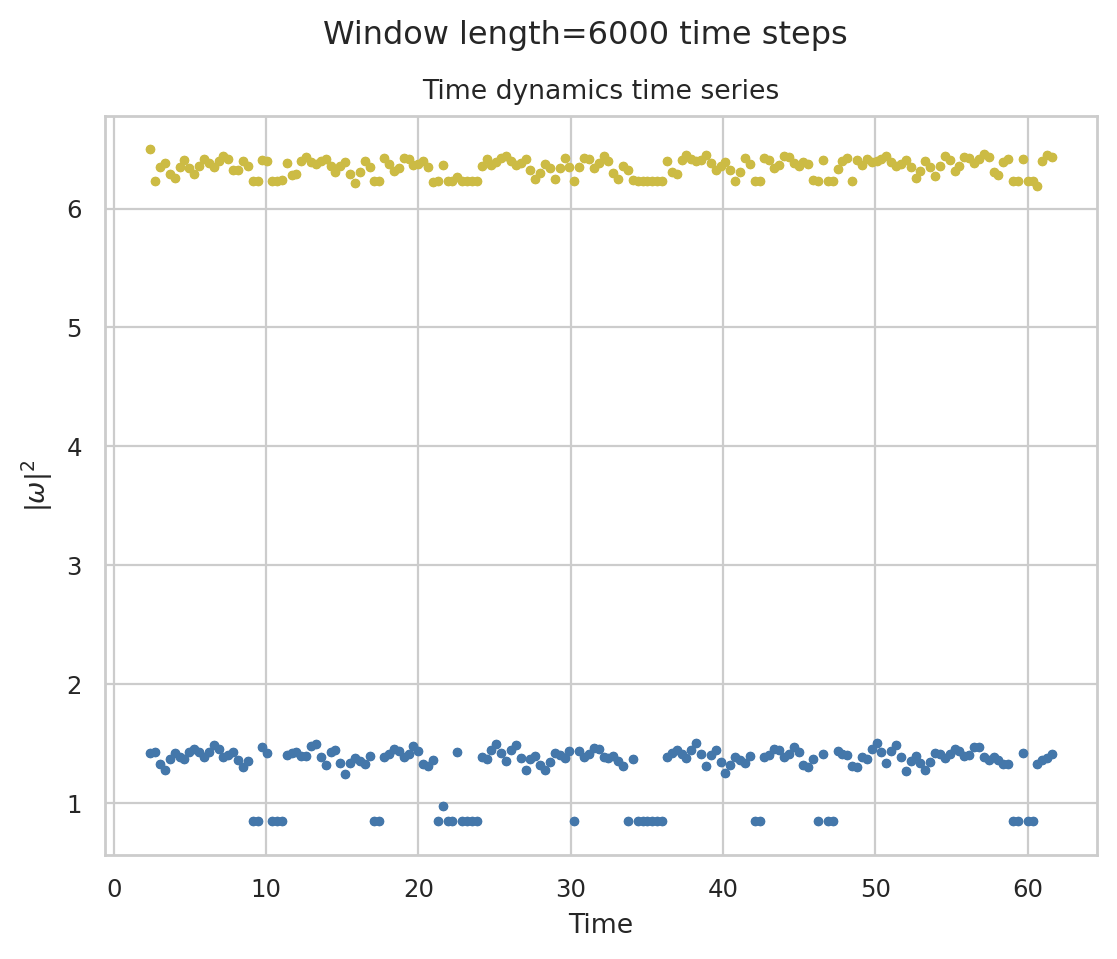

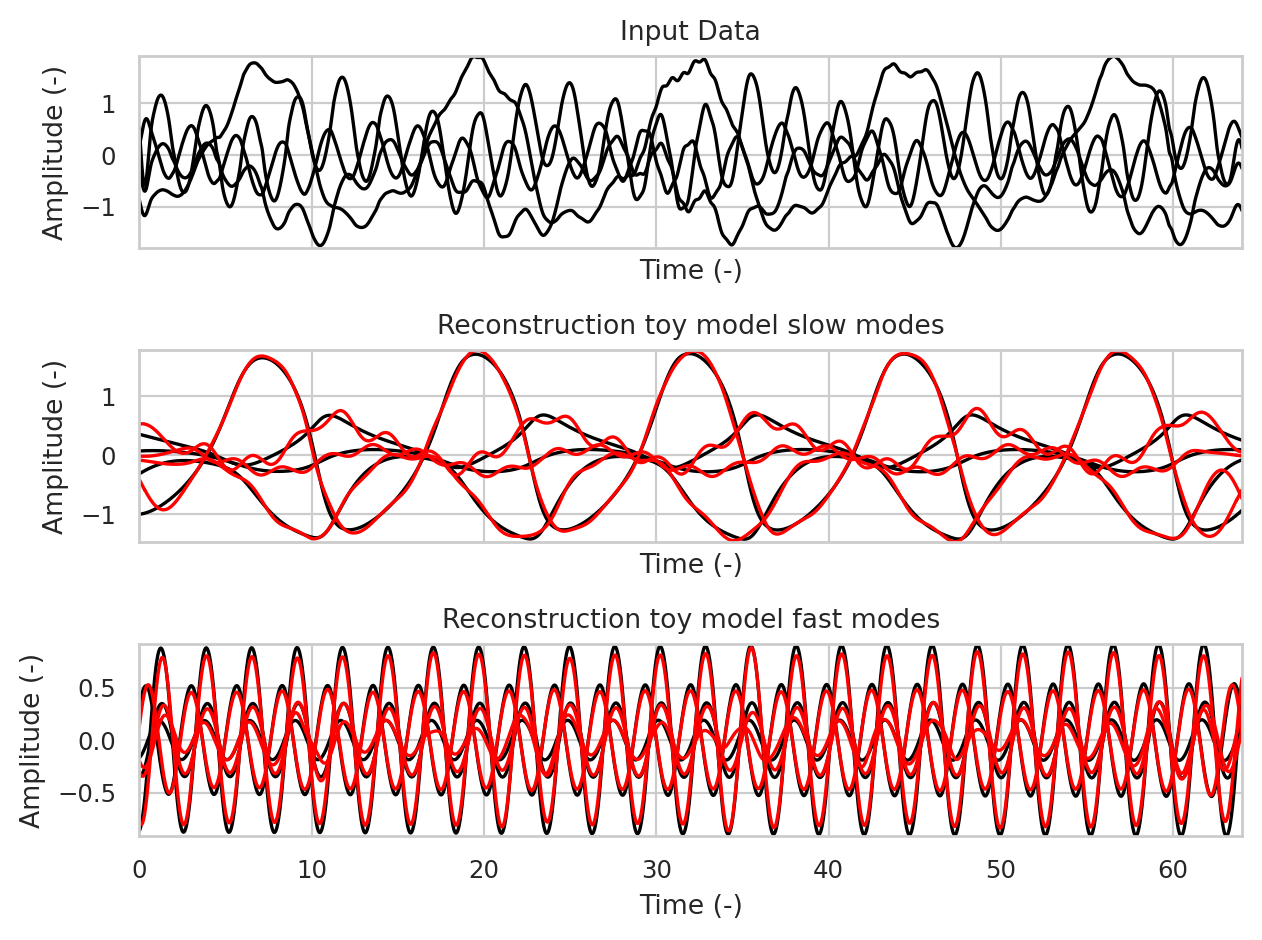

In [16]:
for mrd in mrd_list:
    # Omega histograms and time series.
    window = mrd.window_length
    fig1, ax1 = mrd.plot_omega_histogram()
    fig1.suptitle("Window length={} time steps".format(window))

    fig2, ax2 = mrd.plot_omega_time_series()
    fig2.suptitle("Window length={} time steps".format(window))

    # Scale separation
    xr_sep = mrd.scale_reconstruction(suppress_growth=suppress_growth)

    fig, axes = plt.subplots(
        len(np.unique(mrd.omega_classes)) + 1, 1, sharex=True
    )
    ax = axes[0]
    ax.plot(time.squeeze(), x_iter.T, color="k")
    ax.set_ylabel("Amplitude (-)")
    ax.set_xlabel("Time (-)")
    ax.set_title("Input Data")
    ax.autoscale(enable=True, axis="both", tight=True)

    # Change the underlying data depending on which feature is being separated.
    if np.max(mrd.cluster_centroids) > 50:
        axes[1].plot(time.squeeze(), x.T, color="k")
        axes[1].set_title("Reconstruction toy model")
        axes[2].plot(time.squeeze(), x_transient.T, color="k")
        axes[2].set_title("Reconstruction transient wave packet")

    elif (np.max(mrd.cluster_centroids) > 1) & (
        np.max(mrd.cluster_centroids) < 50
    ):
        axes[1].plot(time.squeeze(), slow_modes, color="k")
        axes[1].set_title("Reconstruction toy model slow modes")
        axes[2].plot(time.squeeze(), fast_modes, color="k")
        axes[2].set_title("Reconstruction toy model fast modes")

    for no, o in enumerate(np.unique(mrd.omega_classes)):
        ax = axes[no + 1]
        ax.plot(time.squeeze(), xr_sep[no, :, :].T, "r")
        ax.set_ylabel("Amplitude (-)")
        ax.set_xlabel("Time (-)")
        ax.autoscale(enable=True, axis="both", tight=True)

    fig.tight_layout()

## Notes

- The fast and slow modes from the toy data set are even better separated than in the original paper. But, not too surprising given how we engineered this toy data set to be better separable with svd-based methods by reducing the condition number.
- Better fast/slow mode separation could probably still be attained by running mrCOSTS at a further decomposition level due to the frequency band leaking (note the wiggles in the slow components of the reconstruction).
- The white noise dropped out in the first level, which is a desirable side effect.
- The transient feature had to be engineered to be detectable using `global_svd=True`. Otherwise the mrCOSTS fitting is very slow. We achieved this by making it the wave packet very wide. It is possible to isolate more localized transient features with `global_svd=False` but this is prohibitively expenseive for a tutorial.